*This notebook was developed by Marina Ricci for the DESC CL_Cosmo_Pipeline team.*
# This notebook aims at presenting the cluster pipeline for 
# stacked $\Delta\Sigma$ profiles and counts in richness/redshift bins.

It is meant to be run independently. If you already produced the necessary outputs `ceci` will use them, and otherwise create them.

___

In [1]:
import os
from pprint import pprint

import ceci
import h5py

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import yaml
from IPython.display import Image
from astropy.table import Table

import re
import sacc

Make sure to change your path in the next cell that leads to your TXPipe directory. See examples for IN2P3 and NERSC below.

In [2]:
# user specific paths -- IN2P3 example
my_txpipe_dir = "/pbs/home/m/mricci/throng_mricci/desc/TXPipe"

# user specific paths -- NERSC example
# my_txpipe_dir = "/pscratch/sd/a/avestruz/TXPipe"

os.chdir(my_txpipe_dir)

import txpipe

___

# 1 - Launching the pipeline

## **Pipeline approach**

Here we will use the 20deg2, but we can also use the 1deg2 files (just need to change 20deg2 to 1deg2 in the name of the files)


Let's have a look at the submission script for this pipeline:
- to work at CCin2p3 we can use: `examples/cosmodc2/Cluster_pipelines/cosmodc2/20deg2-in2p3.sub`:
- to work at NERSC we can use: `examples/cosmodc2/Cluster_pipelines/cosmodc2/20deg2-nersc.sub`:

## **Comands to run the pipeline**
This will launch a job of up to one hour (it should finish in 30 min) on a single CC-IN2P3 node to run a pipeline. After the first run, the output files are created and following runs take much less time.




> ### In a terminal, **navigate to your TXPipe directory on IN2P3 and run**:
>```
sbatch examples/cosmodc2/Cluster_pipelines/20deg2-in2p3.sub
```


> ### If you are **on NERSC, you will instead run**:
>```
sbatch examples/cosmodc2/Cluster_pipelines/20deg2-nersc.sub
```

If you are at CCin2p3 you can look at the ouput of your submission in the file `slurm-xxx.out`, with xxx the number of your batch process. If you see *'Pipeline successful.  Joy is sparked.'* : congratulations, it worked ! 

Once the pipeline is run you can go directly to 4) to look at the results.

___

# 2 - Looking at the different pipeline files

### **Let's look at the submission script :**

=> If we use the CCin2p3 example:

In [3]:
! cat examples/cosmodc2/Cluster_pipelines/20deg2-in2p3.sub

#!/usr/bin/bash
#SBATCH --time=01:00:00
#SBATCH --partition=hpc
#SBATCH --ntasks=30
#SBATCH --cpus-per-task=1
#SBATCH --mem=128000

source ./conda/bin/activate
export HDF5_DO_MPI_FILE_SYNC=0
ceci examples/cosmodc2/Cluster_pipelines/pipeline-20deg2-CL-in2p3.yml


=> If we use the NERSC example:

In [4]:
! cat examples/cosmodc2/Cluster_pipelines/20deg2-nersc.sub

#!/bin/bash
#SBATCH -A m1727
#SBATCH -C cpu
#SBATCH --qos=debug
#SBATCH --time=00:30:00
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=32


module load python
conda activate ./conda
ceci examples/cosmodc2/Cluster_pipelines/pipeline-20deg2-CL-nersc.yml


### **The submission script is specifying the pipeline yaml file. Let's look at it :**

=> The only differences between NERSC and CCin2p3 are in the first block, that defines on witch machine your run. 

In [5]:
! cat examples/cosmodc2/Cluster_pipelines/pipeline-20deg2-CL-nersc.yml

#this step depends on where you run
#for CCin2p3
# site:
#     name: cc-parallel
#     mpi_command: "mpirun -n"

#for NERSC
site:
    name: nersc-interactive


#all the following steps should not depend on where you run 
launcher:
    name: mini
    interval: 3.0
modules: >
    txpipe
    rail.estimation.algos.bpz_lite

python_paths: []

stages:
  - name: TXSourceSelectorMetadetect
    nprocess: 30
  - name: BPZliteInformer
    nprocess: 1
    aliases:
        input: spectroscopic_catalog
        model: photoz_model
  - name: BPZliteEstimator
    nprocess: 30
    aliases:
        model: photoz_model
        input: shear_catalog
        output: source_photoz_pdfs
  - name: CLClusterBinningRedshiftRichness
    nprocess: 1
  - name: CLClusterShearCatalogs
    nprocess: 32   #>1 does not work with mpi
  - name: CLClusterEnsembleProfiles
    nprocess: 1
  - name: CLClusterSACC
    nprocess: 1
    aliases:
        cluster_profiles: cluster_profiles
#    - name: CLClusterDataVector
#      npr

___

# 3 - Producing and looking at the pipeline diagram

Here we run the pipeline in "dry-run" mode, to check that it can run and to produce a pipeline diagram in png.

In [6]:
# Read the appropriate pipeline configuration, and ask for a flow-chart.

pipeline_file = "examples/cosmodc2/Cluster_pipelines/pipeline-20deg2-CL-in2p3.yml"
# pipeline_file = "examples/cosmodc2/Cluster_pipelines/pipeline-20deg2-CL-nersc.yml"
flowchart_file = "CL_pipeline.png"


pipeline_config = ceci.Pipeline.build_config(pipeline_file, flow_chart=flowchart_file, dry_run=True)

# Run the flow-chart pipeline
ceci.run_pipeline(pipeline_config);

Here we have 6 uncommented stages, and 5 uncommented inputs files.

This translate in the pipeline charts as 6 red ellipses, and 5 yellow boxes. The blue boxes represents the ouput files.

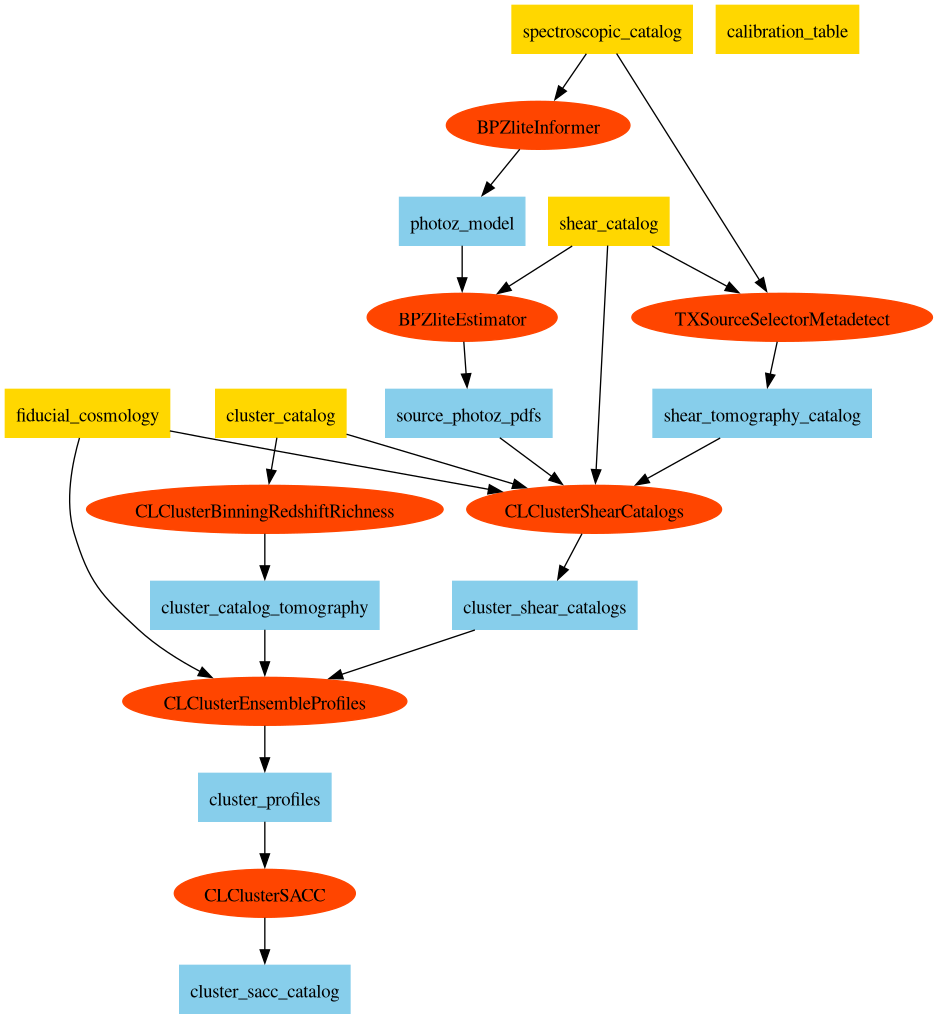

In [7]:
Image(flowchart_file)

___

# 4 - Opening and looking at the outputs

In [8]:
#At the moment the ouput file is a pickle file
import pickle as pkl

### **Open the pipeline file to load correct input/output file names**

In [9]:
with open(pipeline_file, "r") as file:
    pipeline_content = yaml.safe_load(file)

### **Open the output**

In [10]:
data = pkl.load(open(pipeline_content["output_dir"] + "/cluster_profiles.pkl", "rb"))

/pbs/throng/lsst/users/mricci/desc/TXPipe/conda/lib/python3.10/site-packages/clmm/gcdata.py:80: UserWarning: coordinate_system not set, defaulting to 'euclidean'
  warnings.warn("coordinate_system not set, defaulting to 'euclidean'")
/pbs/throng/lsst/users/mricci/desc/TXPipe/conda/lib/python3.10/site-packages/clmm/gcdata.py:80: UserWarning: coordinate_system not set, defaulting to 'euclidean'
  warnings.warn("coordinate_system not set, defaulting to 'euclidean'")
/pbs/throng/lsst/users/mricci/desc/TXPipe/conda/lib/python3.10/site-packages/clmm/gcdata.py:80: UserWarning: coordinate_system not set, defaulting to 'euclidean'
  warnings.warn("coordinate_system not set, defaulting to 'euclidean'")
/pbs/throng/lsst/users/mricci/desc/TXPipe/conda/lib/python3.10/site-packages/clmm/gcdata.py:80: UserWarning: coordinate_system not set, defaulting to 'euclidean'
  warnings.warn("coordinate_system not set, defaulting to 'euclidean'")
/pbs/throng/lsst/users/mricci/desc/TXPipe/conda/lib/python3.10/s

In [11]:
data

{'bin_zbin_0_richbin_0': {'cluster_bin_edges': {'rich_max': 20.0,
   'rich_min': 10.0,
   'z_max': 0.4,
   'z_min': 0.2},
  'n_cl': 37,
  'clmm_cluster_ensemble': <clmm.clusterensemble.ClusterEnsemble at 0x7fbda852c0d0>},
 'bin_zbin_0_richbin_1': {'cluster_bin_edges': {'rich_max': 35.0,
   'rich_min': 20.0,
   'z_max': 0.4,
   'z_min': 0.2},
  'n_cl': 11,
  'clmm_cluster_ensemble': <clmm.clusterensemble.ClusterEnsemble at 0x7fbda528c430>},
 'bin_zbin_0_richbin_2': {'cluster_bin_edges': {'rich_max': 200.0,
   'rich_min': 35.0,
   'z_max': 0.4,
   'z_min': 0.2},
  'n_cl': 4,
  'clmm_cluster_ensemble': <clmm.clusterensemble.ClusterEnsemble at 0x7fbda528d2d0>},
 'bin_zbin_1_richbin_0': {'cluster_bin_edges': {'rich_max': 20.0,
   'rich_min': 10.0,
   'z_max': 0.6,
   'z_min': 0.4},
  'n_cl': 120,
  'clmm_cluster_ensemble': <clmm.clusterensemble.ClusterEnsemble at 0x7fbda528db10>},
 'bin_zbin_1_richbin_1': {'cluster_bin_edges': {'rich_max': 35.0,
   'rich_min': 20.0,
   'z_max': 0.6,
   'z_m

The output is a dictionary containing a `CLMM` `ClusterEnsemble` object for each redshift/richness bin.

### **Exploring the output**

In [12]:
example_bin = 'bin_zbin_0_richbin_0'

In [13]:
#This is the info for this bin
data[example_bin]

{'cluster_bin_edges': {'rich_max': 20.0,
  'rich_min': 10.0,
  'z_max': 0.4,
  'z_min': 0.2},
 'n_cl': 37,
 'clmm_cluster_ensemble': <clmm.clusterensemble.ClusterEnsemble at 0x7fbda852c0d0>}

In [14]:
#This shows the table with all cluster in this bin and their corresponding profiles
data[example_bin]['clmm_cluster_ensemble'].data

cluster_id,ra,dec,z,radius,tangential_comp,cross_comp,W_l
str5,float64,float64,float64,float64[10],float64[10],float64[10],float64[10]
5100,57.42736233046828,-25.90286539931092,0.27140310406684875,0.5894111617370928 .. 8.750984338163171,157950891210161.75 .. 2637797813035.7393,29363405037392.582 .. -2687378395149.9927,245.0 .. 17793.0
5796,53.08602691840102,-26.170606342706584,0.3653298318386078,0.5959044608726264 .. 8.769051934163308,165016214375334.47 .. -11265550765715.023,-5588350818030.948 .. 2602449442074.081,136.0 .. 31248.0
5842,57.351295014363075,-25.743409351835105,0.362968385219574,0.6010559314894848 .. 8.736236174197119,68476286690451.41 .. 3943276169595.6743,71362331791280.56 .. 4497724165848.815,173.0 .. 12963.0
8463,53.248531377151686,-25.180069827109925,0.25667276978492737,0.594165254906906 .. 8.710449353174422,117459895093764.1 .. 8450288200443.802,7389652409987.53 .. 3450460186424.8228,292.0 .. 27286.0
6542,54.81645634894147,-27.479720497282113,0.3937351703643799,0.5930295140268991 .. 8.755980591137705,98463265352827.64 .. 16243187091879.41,-53917791707564.37 .. -1195313606076.978,97.0 .. 29591.0
8273,53.445037522076305,-27.052399365316937,0.34181296825408936,0.5859372438498557 .. 8.759040351692882,-102679410350817.78 .. 4698303532692.31,56256698389608.6 .. -4275571411053.7036,159.0 .. 35549.0
9114,57.38106745488189,-25.752236047617988,0.2713894546031952,0.59863339941745 .. 8.771574468827508,-35890178660396.47 .. 10947438435070.438,1967942639424.3518 .. -43002235442.78081,240.0 .. 19359.0
10543,56.436311391508475,-26.82699595792468,0.299254447221756,0.5910847268211293 .. 8.759456435817881,-29668488555199.973 .. 11687245926456.055,-73575919718148.56 .. 3939112596809.2866,205.0 .. 26453.0
9853,55.17041992869908,-25.818196180591098,0.310738205909729,0.5877797428632585 .. 8.771137029600116,56062204820736.97 .. 6811222270566.694,-72252322867876.97 .. 2583221807209.9287,203.0 .. 28046.0


In [15]:
#This shows the table with all cluster in this bin and their corresponding profiles
data[example_bin]['clmm_cluster_ensemble'].data.meta

GCMetaData([('cosmo',
             'CCLCosmology(H0=71.0, Omega_dm0=0.2199999, Omega_b0=0.0448, Omega_k0=0.0)'),
            ('bin_units', 'Mpc'),
            ('radius_min', [0.5        0.67464142 ... 5.49280272 7.41134449]),
            ('radius_max',
             [ 0.67464142  0.9102821 ... 7.41134449 10.        ]),
            ('coordinate_system', 'euclidean')])

In [16]:
#This shows the ensemble stacked profiles
data[example_bin]['clmm_cluster_ensemble'].stacked_data.meta

GCMetaData([('cosmo',
             'CCLCosmology(H0=71.0, Omega_dm0=0.2199999, Omega_b0=0.0448, Omega_k0=0.0)'),
            ('bin_units', 'Mpc'),
            ('coordinate_system', 'euclidean')])

In [17]:
#This shows the covarinace for the ensemble stacked profiles
data[example_bin]['clmm_cluster_ensemble'].cov

{'tan_sc': array([[ 1.52130842e+26, -7.35401853e+24,  8.75996462e+24,
          1.36845059e+24,  2.61305738e+24, -1.71030308e+24,
          2.96917699e+24,  1.60951744e+24,  5.60807910e+24,
          8.24311885e+23],
        [-7.35401853e+24,  8.79220310e+25, -6.54523149e+24,
          3.62293007e+24, -5.56809343e+24,  4.82372789e+24,
          9.92698306e+23, -1.18796957e+24, -4.77324023e+23,
         -3.73037649e+22],
        [ 8.75996462e+24, -6.54523149e+24,  3.26694780e+25,
          9.95709162e+23,  5.08795612e+24,  3.16432485e+24,
          1.90447538e+24, -3.03611675e+23,  8.08111181e+23,
         -1.52606539e+24],
        [ 1.36845059e+24,  3.62293007e+24,  9.95709162e+23,
          1.85782105e+25,  2.44327934e+24,  1.48598704e+24,
          4.72145506e+24, -4.85580797e+23,  9.32367197e+23,
          6.90423828e+23],
        [ 2.61305738e+24, -5.56809343e+24,  5.08795612e+24,
          2.44327934e+24,  1.41932533e+25,  1.16253083e+24,
          3.52897335e+24, -1.76425682e+22,

### **Plot the ouput**

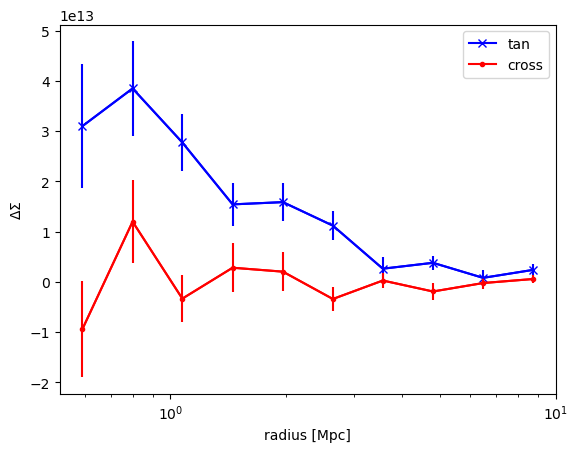

In [18]:
fig, ax = plt.subplots()

ax.semilogx(
        data[example_bin]['clmm_cluster_ensemble'].stacked_data["radius"],
        data[example_bin]['clmm_cluster_ensemble'].stacked_data["tangential_comp"],
        "bx-",
        label="tan",)

ax.semilogx(
        data[example_bin]['clmm_cluster_ensemble'].stacked_data["radius"],
        data[example_bin]['clmm_cluster_ensemble'].stacked_data["cross_comp"],
        "r.-",
        label="cross",)

ax.errorbar(
        data[example_bin]['clmm_cluster_ensemble'].stacked_data["radius"],
        data[example_bin]['clmm_cluster_ensemble'].stacked_data["tangential_comp"],
        yerr=data[example_bin]['clmm_cluster_ensemble'].cov["tan_sc"].diagonal() ** 0.5,
        color="blue",)


ax.errorbar(
        data[example_bin]['clmm_cluster_ensemble'].stacked_data["radius"],
        data[example_bin]['clmm_cluster_ensemble'].stacked_data["cross_comp"],
        yerr=data[example_bin]['clmm_cluster_ensemble'].cov["cross_sc"].diagonal() ** 0.5,
        color="red",)



ax.set_xlabel('radius [Mpc]')
ax.set_ylabel('$\\Delta \\Sigma$')

plt.legend()